In [1]:
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
pd.set_option('display.max_columns', None)
import time
import warnings
warnings.filterwarnings("ignore")

import torch
random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [2]:
# load dataset
df = pd.read_csv(open('./data/diva/processed_diva.csv'))
df = df.drop(np.where(np.prod(~df.isnull().values,axis=1)==0)[0])
df.COD_STATO_DOC = df.COD_STATO_DOC.values.astype(str)
df = df.reset_index(drop=True)
y = (df.CNR_S_AND_EXT_Obi==3)+0
df = df.drop('CNR_S_AND_EXT_Obi',axis=1)

drop = []
continuous = []
categorical = []

for i in df.columns:
    if len(df.loc[:,i].unique())>110:
        continuous.append(i)
    elif len(df.loc[:,i].unique())==1:
        drop.append(i)
    else:
        categorical.append(i)

strings = ['cod_uff_prov_gen','cod_uff_ann_gen','INNESCO','TIPOLOGIA_CON','SETT_IMP','COD_MOD_DICH','COD_STATO_DOC']
for s in strings:
    categorical.remove(s)

df = df.drop(drop,axis=1)

from sklearn import preprocessing

cont_df = df.loc[:,continuous]
cont_df = preprocessing.RobustScaler().fit_transform(cont_df)
min_max_scaler = preprocessing.MinMaxScaler([-1,1])
cont_df = min_max_scaler.fit_transform(cont_df)
cont_df = pd.DataFrame(cont_df,columns=continuous)

cat_num_df = df.loc[:,categorical]
hot_enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
hot_enc.fit(cat_num_df)
names = []
for i in range(len(cat_num_df.columns)):
    for j in range(len(hot_enc.categories_[i])):
        names.append(cat_num_df.columns[i]+'_'+str(hot_enc.categories_[i][j]))
cat_num_df[names]=hot_enc.transform(cat_num_df).toarray().astype(int)
cat_num_df = cat_num_df.drop(categorical,axis=1)

cat_str_df = df.loc[:,strings]
hot_enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
hot_enc.fit(cat_str_df)
names = []
for i in range(len(cat_str_df.columns)):
    for j in range(len(hot_enc.categories_[i])):
        names.append(cat_str_df.columns[i]+'_'+str(hot_enc.categories_[i][j]))
cat_str_df[names]=hot_enc.transform(cat_str_df).toarray().astype(int)
cat_str_df = cat_str_df.drop(strings,axis=1)

df = pd.concat([cont_df,cat_num_df,cat_str_df],axis=1)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df, y, test_size=0.33, random_state=random_seed)

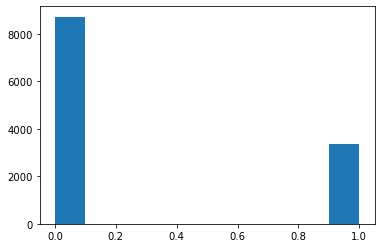

In [4]:
plt.hist(y);

In [5]:
# XGB
from xgboost import XGBClassifier
clf_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
#clf_xgb.fit(X_train, Y_train)
#clf_xgb.save_model(f'./blackboxes/diva_xgboost')
clf_xgb.load_model(f'./blackboxes/diva_xgboost')
y_train_pred = clf_xgb.predict(X_train)
y_test_pred = clf_xgb.predict(X_test)
print('XGB')
print('train acc:',np.mean(np.round(y_train_pred)==Y_train))
print('test acc:',np.mean(np.round(y_test_pred)==Y_test))

#RF
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(min_samples_split=3,random_state=random_seed)
#clf_rf.fit(X_train, Y_train)
#pickle.dump(clf_rf,open(f'./blackboxes/diva_rf.p','wb'))
clf_rf = pickle.load(open(f'./blackboxes/diva_rf.p','rb'))
y_train_pred = clf_rf.predict(X_train)
y_test_pred = clf_rf.predict(X_test)
print('RF')
print('train acc:',np.mean(np.round(y_train_pred)==Y_train))
print('test acc:',np.mean(np.round(y_test_pred)==Y_test))

#SVC
from sklearn import svm
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import Pipeline
clf = svm.LinearSVC(tol=1e-5)
feature_map_nystroem = Nystroem(n_components=500,n_jobs=-1)
feature_map_nystroem.fit(X_train)
clf_svc = Pipeline([('kernel', feature_map_nystroem), ('model', clf)])
#clf_svc.fit(X_train, Y_train)
#pickle.dump(clf_svc,open(f'./blackboxes/diva_svc.p','wb'))
clf_svc = pickle.load(open(f'./blackboxes/diva_svc.p','rb'))
y_train_pred = clf_svc.predict(X_train)
y_test_pred = clf_svc.predict(X_test)
print('SVC')
print('train acc:',np.mean(np.round(y_train_pred)==Y_train))
print('test acc:',np.mean(np.round(y_test_pred)==Y_test))

#NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
BATCH_SIZE = 2**13
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(BATCH_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(BATCH_SIZE)
clf_nn = keras.Sequential([
    keras.layers.Dense(units=100, activation='relu', kernel_regularizer=regularizers.L2(1e-4)),
    keras.layers.Dense(units=50, activation='relu', kernel_regularizer=regularizers.L2(1e-4)),
    keras.layers.Dense(units=1, activation='sigmoid'),
])
early_stopping = EarlyStopping(patience=5)
clf_nn.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
#history = clf_nn.fit(
#    train_dataset,
#    validation_data=test_dataset,
#    epochs=500,
#    callbacks=[early_stopping],
#    verbose=0
#)
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.grid()
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

#plot_metric(history, 'loss')
#clf_nn.save_weights(f'./blackboxes/diva_tf_nn')
from sklearn.metrics import accuracy_score
clf_nn.load_weights(f'./blackboxes/diva_tf_nn')
clf_nn.trainable = False
print('NN')
print(accuracy_score(np.round(clf_nn.predict(X_train.values)),Y_train))
print(accuracy_score(np.round(clf_nn.predict(X_test.values)),Y_test))

XGB
train acc: 0.9993830207305034
test acc: 0.927122464312547
RF
train acc: 0.9998766041461007
test acc: 0.9048334585524668
SVC
train acc: 0.8535291214215203
test acc: 0.8537440520911596


2022-08-05 15:44:51.612094: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-05 15:44:51.635231: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:258] None of the MLIR optimization passes are enabled (registered 0 passes)


NN
0.907329713721619
0.8657650889055848


In [6]:
black_box = 'xgb'

if black_box=='xgb':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_xgb.predict_proba(x)[:,1].ravel()
        else: return clf_xgb.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
elif black_box=='rf':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_rf.predict_proba(x)[:,1].ravel()
        else: return clf_rf.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
elif black_box=='svc':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_svc.predict_proba(x)[:,1].ravel()
        else: return clf_svc.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
elif black_box=='nn':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_nn.predict(x).ravel()
        else: return np.round(clf_nn.predict(x).ravel()).astype(int).ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)

# Baseline 1-KNN

In [67]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train, Y_train)

print(accuracy_score(neigh.predict(X_test),Y_test))

0.8372151264713248


# Proto Select

In [23]:
from alibi.prototypes import ProtoSelect
from alibi.utils.kernel import EuclideanDistance

summariser = ProtoSelect(kernel_distance=EuclideanDistance(), eps=5)
summariser = summariser.fit(X=X_train.values, y=Y_train.values)
summary = summariser.summarise(num_prototypes=10)

In [24]:
pd.DataFrame(summary.prototypes, columns=X_train.columns)

,PESO,RIMB_NON_CONC,IVA_OP_IMPON_DIC,CREDITI_IVA_DIC,VOL_AFF_DICH,VOL_ACC_DEF,DETR_IVA_DIC,DETR_IVA_ACC,MAG_IMP_RIT_ACC,MAG_IMP_RIT_DEF,IMP_BEN_AMM,IMP_BEN_NO_AMM,IMP_BENI_ALTRI,IMP_INTRA_IMPOST,IMP_IMPOR_IMPON,IMP_IMPOR_IMPOST,IMP_ESPORTAZ,IMP_OPER_INT,IMP_VE_OPESEN,IMP_OPER_NOIMP,IMP_CESS_BENI,IMP_VE_VOLAFF,IMP_ACQ_NOIMP,IMP_ACQ_ESENTI,IMP_ACQ_NODETR,IMP_OPER,IMP_IVA_DEB,IMP_CREDAP_COMP,IMP_CRED_AP,IMP_VERS_PERIOD,IMP_CONSUM_IMPON,IMP_SOGG_IVA_IMPON,IMP_V_AGG_IMPON,IMP_V_AGG_IVA,VAL_ALIQ_M_VOL_IMP,VAL_ALIQ_M_ACQ_IMP,VAL_ALIQ_MEDIA_VOL,VAL_ALIQ_MEDIA_ACQ,IMP_UTIL_CONTEC,IMP_PERD_CONTEC,IMP_RIM_FINALI,IMP_ESISTZ,IMP_IMPST_NETTA,IMP_ECC_PREC,IMP_ECC_PREC_F24,IMP_IMPST_DEBITO,IMP_IMPST_CREDIT,imp_ricavi_comp_attiv,imp_tot_pos,imp_sps_prest_lavoro,imp_tot_neg,imp_redd_lrd_attiv,imp_redd_imp_attiv,VAR_CREDITO,VAR_RIMBORSO,VAR_DETRAZIONE,VAR_VOL_AFF_POS,VAR_VOL_AFF_NEG,ANN_IMPST_2000,ANN_IMPST_2001,ANN_IMPST_2002,ANN_IMPST_2003,ANN_IMPST_2004,ANN_IMPST_2005,TIPO_DICH_ACCERT_1,TIPO_DICH_ACCERT_2,TIPO_DICH_ACCERT_3,TIPO_DICH_ACCERT_4,TIPO_DICH_ACCERT_6,FLG_PRES_ADESIONE_0,FLG_PRES_ADESIONE_1,FLG_PRES_RICORSO_0,FLG_PRES_RICORSO_1,PESO_ADESIONE_0,PESO_ADESIONE_6,PESO_ADESIONE_8,PESO_ADESIONE_12,PESO_ADESIONE_16,PESO_ADESIONE_18,PESO_ADESIONE_19,PESO_ADESIONE_24,PESO_ADESIONE_27,PESO_ADESIONE_29,PESO_ADESIONE_30,PESO_ADESIONE_36,PESO_ADESIONE_38,PESO_ADESIONE_48,PESO_ADESIONE_54,AFFIDABILITA_0,AFFIDABILITA_1,AFFIDABILITA_2,AFFIDABILITA_3,AFFIDABILITA_4,AFFIDABILITA_5,SOLVIBILITA_0,SOLVIBILITA_1,SOLVIBILITA_2,SOLVIBILITA_3,SOLVIBILITA_4,SOLVIBILITA_5,STATO_CONTROLLO_2,STATO_CONTROLLO_3,STATO_CONTROLLO_5,STATO_CONTROLLO_6,STATO_CONTROLLO_8,STATO_CONTROLLO_9,STATO_CONTROLLO_10,STATO_CONTROLLO_11,STATO_CONTROLLO_12,STATO_CONTROLLO_13,STATO_CONTROLLO_15,STATO_CONTROLLO_17,STATO_CONTROLLO_18,STATO_CONTROLLO_19,STATO_CONTROLLO_20,STATO_CONTROLLO_21,STATO_CONTROLLO_22,STATO_CONTROLLO_23,STATO_CONTROLLO_24,STATO_CONTROLLO_29,STATO_CONTROLLO_30,STATO_CONTROLLO_34,STATO_CONTROLLO_35,STATO_CONTROLLO_36,FL_CONDONO_0,FL_CONDONO_1,FL_CONDONO_2,FL_CONDONO_3,FL_CONDONO_4,FL_CONDONO_9,RIMB_NON_CONC_DEF_0.0,RIMB_NON_CONC_DEF_90.38,RIMB_NON_CONC_DEF_398.7,RIMB_NON_CONC_DEF_1490.0,RIMB_NON_CONC_DEF_2000.0,RIMB_NON_CONC_DEF_2120.06,RIMB_NON_CONC_DEF_2175.0,RIMB_NON_CONC_DEF_2260.0,RIMB_NON_CONC_DEF_2417.0,RIMB_NON_CONC_DEF_2469.7,RIMB_NON_CONC_DEF_2582.28,RIMB_NON_CONC_DEF_4000.0,RIMB_NON_CONC_DEF_4906.34,RIMB_NON_CONC_DEF_5131.0,RIMB_NON_CONC_DEF_5405.0,RIMB_NON_CONC_DEF_5612.85,RIMB_NON_CONC_DEF_10143.0,RIMB_NON_CONC_DEF_10500.09,RIMB_NON_CONC_DEF_10641.0,RIMB_NON_CONC_DEF_23240.56,RIMB_NON_CONC_DEF_24000.0,RIMB_NON_CONC_DEF_25939.0,RIMB_NON_CONC_DEF_28000.0,RIMB_NON_CONC_DEF_40000.0,RIMB_NON_CONC_DEF_42175.0,RIMB_NON_CONC_DEF_51645.69,RIMB_NON_CONC_DEF_80000.0,RIMB_NON_CONC_DEF_90000.0,RIMB_NON_CONC_DEF_299002.72,RIMB_NON_CONC_DEF_400000.0,RIMB_NON_CONC_DEF_444297.0,RIMB_NON_CONC_DEF_1345000.0,RIMB_NON_CONC_DEF_1634000.0,RIMB_NON_CONC_DEF_2024000.0,RIMB_NON_CONC_DEF_2284778.0,DEBITO_IMPOSTA_AUT_0.0,DEBITO_IMPOSTA_AUT_312.0,DEBITO_IMPOSTA_AUT_431.76,DEBITO_IMPOSTA_AUT_438.0,DEBITO_IMPOSTA_AUT_1862.0,DEBITO_IMPOSTA_AUT_2518.0,DEBITO_IMPOSTA_AUT_3953.0,DEBITO_IMPOSTA_AUT_6780.0,DEBITO_IMPOSTA_AUT_28800.0,DEBITO_IMPOSTA_AUT_53702.0,FLG_PRES_RISCOSS_0,FLG_PRES_RISCOSS_1,INDAGINE_BANCARIA_0,INDAGINE_BANCARIA_1,MAG_IMP_IRPEF_ACC_0.0,MAG_IMP_IRPEF_ACC_12.91,MAG_IMP_IRPEF_ACC_2827.09,MAG_IMP_IRPEF_ACC_2928.83,MAG_IMP_IRPEF_ACC_4780.33,MAG_IMP_IRPEF_ACC_6617.0,MAG_IMP_IRPEF_ACC_28193.0,MAG_IMP_IRPEF_ACC_30788.0,MAG_IMP_IRPEF_DEF_0.0,MAG_IMP_IRPEF_DEF_12.91,MAG_IMP_IRPEF_DEF_2283.77,MAG_IMP_IRPEF_DEF_2827.09,MAG_IMP_IRPEF_DEF_4780.33,MAG_IMP_IRPEF_DEF_6617.0,MAG_IMP_IRPEF_DEF_30788.0,DEBITI_IVA_DIC_0.0,DEBITI_IVA_DIC_31028.73,DEBITI_IVA_DIC_9354830.0,COD_CLASSE_VOLUME_0,COD_CLASSE_VOLUME_1,COD_CLASSE_VOLUME_2,COD_CLASSE_VOLUME_3,COD_CLASSE_VOLUME_4,COD_CLASSE_VOLUME_5,COD_CLASSE_VOLUME_6,COD_CLASSE_VOLUME_7,COD_CLASSE_VOLUME_8,FLG_PRES_BILANCIO_0,FLG_PRES_BILANCIO_1

In [70]:
proto_pred = predict(summary.prototypes)
print('perc positive proto: ', np.mean(proto_pred))

from scipy.spatial.distance import cdist
knn_1 = np.argmin(cdist(summary.prototypes, X_test),axis=0)
d = {}
for i in range(10):
    d[i]=proto_pred[i]
knn_1 = [d[x] for x in knn_1]
print('accuracy 1-KNN:',accuracy_score(knn_1,Y_test))

print('avg_distance:',np.mean(cdist(summary.prototypes,summary.prototypes)))

perc positive proto:  0.3
accuracy 1-KNN: 0.6223390934134736
avg_distance: 5.284017374106549


# ProtoDASH

In [10]:
from protodash import ProtodashExplainer, get_Gaussian_Data

explainer = ProtodashExplainer()

# call protodash explainer
# S contains indices of the selected prototypes
# W contains importance weights associated with the selected prototypes 
(W, S, _) = explainer.explain(X_train.values, X_train.values, m=5) 

In [11]:
inc_prototypes = X_train.iloc[S, :].copy()
inc_prototypes

,PESO,RIMB_NON_CONC,IVA_OP_IMPON_DIC,CREDITI_IVA_DIC,VOL_AFF_DICH,VOL_ACC_DEF,DETR_IVA_DIC,DETR_IVA_ACC,MAG_IMP_RIT_ACC,MAG_IMP_RIT_DEF,IMP_BEN_AMM,IMP_BEN_NO_AMM,IMP_BENI_ALTRI,IMP_INTRA_IMPOST,IMP_IMPOR_IMPON,IMP_IMPOR_IMPOST,IMP_ESPORTAZ,IMP_OPER_INT,IMP_VE_OPESEN,IMP_OPER_NOIMP,IMP_CESS_BENI,IMP_VE_VOLAFF,IMP_ACQ_NOIMP,IMP_ACQ_ESENTI,IMP_ACQ_NODETR,IMP_OPER,IMP_IVA_DEB,IMP_CREDAP_COMP,IMP_CRED_AP,IMP_VERS_PERIOD,IMP_CONSUM_IMPON,IMP_SOGG_IVA_IMPON,IMP_V_AGG_IMPON,IMP_V_AGG_IVA,VAL_ALIQ_M_VOL_IMP,VAL_ALIQ_M_ACQ_IMP,VAL_ALIQ_MEDIA_VOL,VAL_ALIQ_MEDIA_ACQ,IMP_UTIL_CONTEC,IMP_PERD_CONTEC,IMP_RIM_FINALI,IMP_ESISTZ,IMP_IMPST_NETTA,IMP_ECC_PREC,IMP_ECC_PREC_F24,IMP_IMPST_DEBITO,IMP_IMPST_CREDIT,imp_ricavi_comp_attiv,imp_tot_pos,imp_sps_prest_lavoro,imp_tot_neg,imp_redd_lrd_attiv,imp_redd_imp_attiv,VAR_CREDITO,VAR_RIMBORSO,VAR_DETRAZIONE,VAR_VOL_AFF_POS,VAR_VOL_AFF_NEG,ANN_IMPST_2000,ANN_IMPST_2001,ANN_IMPST_2002,ANN_IMPST_2003,ANN_IMPST_2004,ANN_IMPST_2005,TIPO_DICH_ACCERT_1,TIPO_DICH_ACCERT_2,TIPO_DICH_ACCERT_3,TIPO_DICH_ACCERT_4,TIPO_DICH_ACCERT_6,FLG_PRES_ADESIONE_0,FLG_PRES_ADESIONE_1,FLG_PRES_RICORSO_0,FLG_PRES_RICORSO_1,PESO_ADESIONE_0,PESO_ADESIONE_6,PESO_ADESIONE_8,PESO_ADESIONE_12,PESO_ADESIONE_16,PESO_ADESIONE_18,PESO_ADESIONE_19,PESO_ADESIONE_24,PESO_ADESIONE_27,PESO_ADESIONE_29,PESO_ADESIONE_30,PESO_ADESIONE_36,PESO_ADESIONE_38,PESO_ADESIONE_48,PESO_ADESIONE_54,AFFIDABILITA_0,AFFIDABILITA_1,AFFIDABILITA_2,AFFIDABILITA_3,AFFIDABILITA_4,AFFIDABILITA_5,SOLVIBILITA_0,SOLVIBILITA_1,SOLVIBILITA_2,SOLVIBILITA_3,SOLVIBILITA_4,SOLVIBILITA_5,STATO_CONTROLLO_2,STATO_CONTROLLO_3,STATO_CONTROLLO_5,STATO_CONTROLLO_6,STATO_CONTROLLO_8,STATO_CONTROLLO_9,STATO_CONTROLLO_10,STATO_CONTROLLO_11,STATO_CONTROLLO_12,STATO_CONTROLLO_13,STATO_CONTROLLO_15,STATO_CONTROLLO_17,STATO_CONTROLLO_18,STATO_CONTROLLO_19,STATO_CONTROLLO_20,STATO_CONTROLLO_21,STATO_CONTROLLO_22,STATO_CONTROLLO_23,STATO_CONTROLLO_24,STATO_CONTROLLO_29,STATO_CONTROLLO_30,STATO_CONTROLLO_34,STATO_CONTROLLO_35,STATO_CONTROLLO_36,FL_CONDONO_0,FL_CONDONO_1,FL_CONDONO_2,FL_CONDONO_3,FL_CONDONO_4,FL_CONDONO_9,RIMB_NON_CONC_DEF_0.0,RIMB_NON_CONC_DEF_90.38,RIMB_NON_CONC_DEF_398.7,RIMB_NON_CONC_DEF_1490.0,RIMB_NON_CONC_DEF_2000.0,RIMB_NON_CONC_DEF_2120.06,RIMB_NON_CONC_DEF_2175.0,RIMB_NON_CONC_DEF_2260.0,RIMB_NON_CONC_DEF_2417.0,RIMB_NON_CONC_DEF_2469.7,RIMB_NON_CONC_DEF_2582.28,RIMB_NON_CONC_DEF_4000.0,RIMB_NON_CONC_DEF_4906.34,RIMB_NON_CONC_DEF_5131.0,RIMB_NON_CONC_DEF_5405.0,RIMB_NON_CONC_DEF_5612.85,RIMB_NON_CONC_DEF_10143.0,RIMB_NON_CONC_DEF_10500.09,RIMB_NON_CONC_DEF_10641.0,RIMB_NON_CONC_DEF_23240.56,RIMB_NON_CONC_DEF_24000.0,RIMB_NON_CONC_DEF_25939.0,RIMB_NON_CONC_DEF_28000.0,RIMB_NON_CONC_DEF_40000.0,RIMB_NON_CONC_DEF_42175.0,RIMB_NON_CONC_DEF_51645.69,RIMB_NON_CONC_DEF_80000.0,RIMB_NON_CONC_DEF_90000.0,RIMB_NON_CONC_DEF_299002.72,RIMB_NON_CONC_DEF_400000.0,RIMB_NON_CONC_DEF_444297.0,RIMB_NON_CONC_DEF_1345000.0,RIMB_NON_CONC_DEF_1634000.0,RIMB_NON_CONC_DEF_2024000.0,RIMB_NON_CONC_DEF_2284778.0,DEBITO_IMPOSTA_AUT_0.0,DEBITO_IMPOSTA_AUT_312.0,DEBITO_IMPOSTA_AUT_431.76,DEBITO_IMPOSTA_AUT_438.0,DEBITO_IMPOSTA_AUT_1862.0,DEBITO_IMPOSTA_AUT_2518.0,DEBITO_IMPOSTA_AUT_3953.0,DEBITO_IMPOSTA_AUT_6780.0,DEBITO_IMPOSTA_AUT_28800.0,DEBITO_IMPOSTA_AUT_53702.0,FLG_PRES_RISCOSS_0,FLG_PRES_RISCOSS_1,INDAGINE_BANCARIA_0,INDAGINE_BANCARIA_1,MAG_IMP_IRPEF_ACC_0.0,MAG_IMP_IRPEF_ACC_12.91,MAG_IMP_IRPEF_ACC_2827.09,MAG_IMP_IRPEF_ACC_2928.83,MAG_IMP_IRPEF_ACC_4780.33,MAG_IMP_IRPEF_ACC_6617.0,MAG_IMP_IRPEF_ACC_28193.0,MAG_IMP_IRPEF_ACC_30788.0,MAG_IMP_IRPEF_DEF_0.0,MAG_IMP_IRPEF_DEF_12.91,MAG_IMP_IRPEF_DEF_2283.77,MAG_IMP_IRPEF_DEF_2827.09,MAG_IMP_IRPEF_DEF_4780.33,MAG_IMP_IRPEF_DEF_6617.0,MAG_IMP_IRPEF_DEF_30788.0,DEBITI_IVA_DIC_0.0,DEBITI_IVA_DIC_31028.73,DEBITI_IVA_DIC_9354830.0,COD_CLASSE_VOLUME_0,COD_CLASSE_VOLUME_1,COD_CLASSE_VOLUME_2,COD_CLASSE_VOLUME_3,COD_CLASSE_VOLUME_4,COD_CLASSE_VOLUME_5,COD_CLASSE_VOLUME_6,COD_CLASSE_VOLUME_7,COD_CLASSE_VOLUME_8,FLG_PRES_BILANCIO_0,FLG_PRES_BILANCIO_1

In [12]:
predict(inc_prototypes)

array([1, 0, 0, 0, 1])

# MMD Critic

In [13]:
from mmd.mmd_critic import Dataset, select_prototypes, select_criticisms

gamma = 0.026

num_prototypes = 5
num_criticisms = 5

kernel_type = 'local'
# kernel_type = 'global'

# regularizer = None
regularizer = 'logdet'
# regularizer = 'iterative'

d_train = Dataset(torch.tensor(X_train.values, dtype=torch.float), torch.tensor(Y_train.values,dtype=torch.long))
if kernel_type == 'global':
    d_train.compute_rbf_kernel(gamma)
elif kernel_type == 'local':
    d_train.compute_local_rbf_kernel(gamma)
else:
    raise KeyError('kernel_type must be either "global" or "local"')
print('Done.', flush=True)

# Prototypes
print('Computing prototypes...', end='', flush=True)
prototype_indices = select_prototypes(d_train.K, num_prototypes)

prototypes = d_train.X[prototype_indices]
prototype_labels = d_train.y[prototype_indices]

sorted_by_y_indices = prototype_labels.argsort()
prototypes_sorted = prototypes[sorted_by_y_indices]
prototype_labels = prototype_labels[sorted_by_y_indices]
print('Done.', flush=True)
print(prototype_indices.sort()[0].tolist())

# Criticisms
print('Computing criticisms...', end='', flush=True)
criticism_indices = select_criticisms(d_train.K, prototype_indices, num_criticisms, regularizer)

criticisms = d_train.X[criticism_indices]
criticism_labels = d_train.y[criticism_indices]

sorted_by_y_indices = criticism_labels.argsort()
criticisms_sorted = criticisms[sorted_by_y_indices]
criticism_labels = criticism_labels[sorted_by_y_indices]
print('Done.', flush=True)
print(criticism_indices.sort()[0].tolist())

Done.
Computing prototypes...Done.
[1126, 2652, 5111, 5358, 6946]
Computing criticisms...Done.
[1478, 1688, 2530, 5901, 6233]


In [14]:
predict(X_train.values[prototype_indices.sort()[0].tolist()])

array([1, 0, 0, 1, 0])

In [15]:
predict(X_train.values[criticism_indices.sort()[0].tolist()])

array([0, 0, 0, 1, 1])

# Latent

In [7]:
X_train = np.hstack((X_train,y_train_pred.reshape(-1,1)))
X_test = np.hstack((X_test,y_test_pred.reshape(-1,1)))
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Latent Space

latent_dim = 10
batch_size = 2**8
sigma = 1
max_epochs = 1000
early_stopping = 3
learning_rate = 1e-3

idx_cat = list(range(58))

similarity_KLD = torch.nn.KLDivLoss(reduction='batchmean')

def compute_similarity_Z(Z, sigma):
    D = 1 - F.cosine_similarity(Z[:, None, :], Z[None, :, :], dim=-1)
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

def compute_similarity_X(X, sigma, idx_cat=None):
    D_class = torch.cdist(X[:,-1].reshape(-1,1),X[:,-1].reshape(-1,1))
    X = X[:, :-1]
    if idx_cat:
        X_cat = X[:, idx_cat]
        X_cont = X[:, np.delete(range(X.shape[1]),idx_cat)]
        h = X_cat.shape[1]
        m = X.shape[1]
        D_cont = 1 - F.cosine_similarity(X[:, None, :], X[None, :, :], dim=-1)
        D_cat = torch.cdist(X_cat, X_cat, p=0)/h
        D = h/m * D_cat + ((m-h)/m) * D_cont + D_class
    else:
        D_features = 1 - F.cosine_similarity(X[:, None, :], X[None, :, :], dim=-1) 
        D = D_features + D_class
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

def loss_function(X, Z, idx_cat, sigma=1):
    Sx = compute_similarity_X(X, sigma, idx_cat)
    Sz = compute_similarity_Z(Z, sigma)
    loss = similarity_KLD(torch.log(Sx), Sz)
    return loss

class LinearModel(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(LinearModel, self).__init__()

        # encoding components
        self.fc1 = nn.Linear(input_shape, latent_dim)

    def encode(self, x):
        x = self.fc1(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return z

# Create Model
model = LinearModel(X_train.shape[1], latent_dim=latent_dim)

In [8]:
# train_dataset = TensorDataset(torch.tensor(X_train).float())
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
# test_dataset = TensorDataset(torch.tensor(X_test).float())
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

# def check_and_clear(dir_name):
#     if not os.path.exists(dir_name):
#         os.mkdir(dir_name)
#     else:
#         os.system('rm -r ' + dir_name)
#         os.mkdir(dir_name)

# check_and_clear('./models/weights')

# model_params = list(model.parameters())
# optimizer = torch.optim.Adam(model_params, lr=learning_rate)

# # record training process
# epoch_train_losses = []
# epoch_test_losses = []

# #validation parameters
# epoch = 1
# best = np.inf

# # progress bar
# pbar = tqdm(bar_format="{postfix[0]} {postfix[1][value]:03d} {postfix[2]} {postfix[3][value]:.5f} {postfix[4]} {postfix[5][value]:.5f} {postfix[6]} {postfix[7][value]:d}",
#             postfix=["Epoch:", {'value':0}, "Train Sim Loss", {'value':0}, "Test Sim Loss", {'value':0}, "Early Stopping", {"value":0}])

# # start training
# while epoch <= max_epochs:

#     # ------- TRAIN ------- #
#     # set model as training mode
#     model.train()
#     batch_loss = []

#     for batch, (X_batch,) in enumerate(train_loader):
#         optimizer.zero_grad()
#         Z_batch = model(X_batch)  #
#         loss  = loss_function(X_batch, Z_batch, idx_cat, sigma) 
#         loss.backward()
#         optimizer.step()
#         batch_loss.append(loss.item())

#     # save result
#     epoch_train_losses.append(np.mean(batch_loss))
#     pbar.postfix[3]["value"] = np.mean(batch_loss)

#     # -------- VALIDATION --------

#     # set model as testing mode
#     model.eval()
#     batch_loss = []

#     with torch.no_grad():
#         for batch, (X_batch,) in enumerate(test_loader):
#             Z_batch = model(X_batch)
#             loss = loss_function(X_batch, Z_batch, idx_cat, sigma)
#             batch_loss.append(loss.item())

#     # save information
#     epoch_test_losses.append(np.mean(batch_loss))
#     pbar.postfix[5]["value"] = np.mean(batch_loss)
#     pbar.postfix[1]["value"] = epoch

#     if epoch_test_losses[-1] < best:
#         wait = 0
#         best = epoch_test_losses[-1]
#         best_epoch = epoch
#         torch.save(model.state_dict(), f'./models/weights/LinearTransparent_diva.pt')
#     else:
#         wait += 1
#     pbar.postfix[7]["value"] = wait
#     if wait == early_stopping:
#         break    
#     epoch += 1
#     pbar.update()

# model.load_state_dict(torch.load(f'./models/weights/LinearTransparent_diva.pt'))
# with torch.no_grad():
#     model.eval()
#     Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
#     Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

# torch.save(model.state_dict(), f'./models/diva_latent_{black_box}_{latent_dim}.pt')

In [9]:
model.load_state_dict(torch.load(f'./models/diva_latent_{black_box}_{latent_dim}.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

## Latent Kmeans

In [11]:
from sklearn.cluster import SpectralClustering

clustering = SpectralClustering(n_clusters=5,assign_labels='discretize').fit(Z_train)
clustering.labels_

clustering

#from scipy.spatial.distance import cdist
#proto = []
#for i in range(len(bisect_means.cluster_centers_)):
#    proto.append(X_train[np.argmin(cdist(Z_train,bisect_means.cluster_centers_[i:i+1,:]))])
#proto = np.stack(proto)

SpectralClustering(assign_labels='discretize', n_clusters=5)

In [29]:
centers = []
for i in range(5):
    centers.append(np.mean(Z_train[clustering.labels_==i],axis=0))
centers = np.stack(centers)
from scipy.spatial.distance import cdist
idx = np.argmin(cdist(centers,Z_train),axis=1)
predict(X_train[idx,:-1])

array([1, 0, 0, 0, 0])

# Latent Proto Select

In [30]:
from alibi.prototypes import ProtoSelect
from alibi.utils.kernel import EuclideanDistance

summariser = ProtoSelect(kernel_distance=EuclideanDistance(), eps=0.1)
summariser = summariser.fit(X=Z_train, y=Y_train.values)
summary = summariser.summarise(num_prototypes=5)
from scipy.spatial.distance import cdist
idx = np.argmax(cdist(summary.prototypes,Z_train),axis=1)
predict(X_train[idx,:-1])

array([0, 1, 1, 0, 0])